In [1]:
import sys, cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import collections
from dataclasses import dataclass
from tqdm.notebook import tnrange, tqdm
from functools import reduce

# Reading Dumped data

In [2]:
with open('sortedFish.pik','rb') as f:
    sortedFish=pickle.load(f)

posU=sortedFish[0]
nonOverlappingRange=sortedFish[1]
fishU=sortedFish[2]

fishU=frame,fish,pixel,[row,col,grey]

262 30 113.57956808685125 111.0


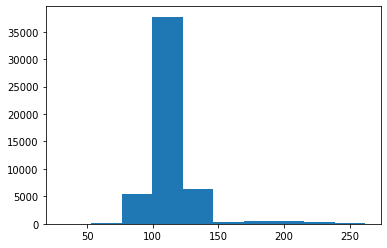

(array([    0,     1,     2, ..., 51211, 51212, 51213], dtype=int64),)


In [3]:
# Pixels should be over 150, here's how many are.
pixelCount=[]
for i in range(len(fishU)):
    pixelCount.append(len(fishU[i][0]))
print(max(pixelCount),min(pixelCount),np.mean(pixelCount),np.median(pixelCount))
plt.hist(pixelCount)
plt.show()
pixelCount=np.array(pixelCount)
print(np.where(pixelCount<150))

# Creating a distance histogram out of the sorted data

### Function to create histograms

In [4]:
def histMaker(histData,bins1,bins2):
    '''
    Creates a 2d histogram.
    
    Input:
        histData:Either histSum or histDif. Some sort of array?
        bins1:The distance bins. np.linspace(int,int,int)
        bins2:The sum/difference bins. np.linspace(int,int,int)
    '''
    #fig=plt.figure(figsize=(5,5))
    
    plt.imshow(histData[:,::-1].T,extent=[bins1[0], bins1[-1], bins2[0], bins2[-1]],aspect='auto')
    plt.colorbar()
    
    #plt.show()

### Creating histograms for two fish over the first n nonoverlapping ranges.

The following 4 cells are 3 different ways of setting the bins that the histograms use. Todo: chose a method that works the best.

In [5]:
binsDist=np.linspace(0,30,30)
binsDif=np.linspace(0,50,50)
binsSum=np.linspace(150,350,200)
histSum=np.zeros((len(binsDist)-1,len(binsSum)-1))
histDif=np.zeros((len(binsDist)-1,len(binsDif)-1))

*Reenable this cell*

This cell creates the histograms from the data. It loops over the number of nonoverlapping ranges and provides a histogram of the brightness sum and difference for each fish.

In [24]:
#binsDist=np.linspace(0,30,30)
#binsDif=np.linspace(0,50,50)
#binsSum=np.linspace(150,350,200)
#histSum=np.zeros((len(binsDist)-1,len(binsSum)-1))
#histDif=np.zeros((len(binsDist)-1,len(binsDif)-1))

histSumList={}
histDifList={}

#i=num nonOverlappingRanges
#k=num fish
#j=frame in nonOverlappingRange
#l=pixels in frame
#m=

for i in tnrange(60,desc='nonOverlappingRange'):
    for k in range(2):
        countSum=0
        countDif=0
        pairData=[]
        for j in range(*nonOverlappingRange[i]):
            fishPixels = fishU[j][k]
            m,l=np.triu_indices(fishPixels.shape[0],k=1)
            d=np.sqrt((fishPixels[l,0]-fishPixels[m,0])**2+(fishPixels[l,1]-fishPixels[m,1])**2)
            bSum=fishPixels[l,2]+fishPixels[m,2]
            bDif=fishPixels[l,2]-fishPixels[m,2]

            heightValuesSum,_,_=np.histogram2d(d,bSum,bins=(binsDist,binsSum))
            histSum+=heightValuesSum
            countSum+=1
            heightValuesDif,_,_=np.histogram2d(d,bDif,bins=(binsDist,binsDif))
            histDif+=heightValuesDif
            countDif+=1
        histSum/=countSum
        #histSumList['nonOverlappingRange%s-fish%s'%(i,k)]=histSum.copy()
        #nonOverlappingRange,fish
        histSumList[i,k]=histSum.copy()
        histDif/=countDif
        #histDifList['nonOverlappingRange%s-fish%s'%(i,k)]=histDif.copy()
        #nonOverlappingRange,fish
        histDifList[i,k]=histDif.copy()

        
histLists=[histSumList,histDifList]
#histLists={'histSumList':histSumList,'histDifList':histDifList}
with open('histLists.pik','wb') as f:
    pickle.dump(histLists,f)

The end of the previous cell writes the data to histLists.pik, so this cell reads back the data.

In [25]:
with open('histLists.pik','rb') as f:
    histLists=pickle.load(f)

#globals().update(histLists)
histSumList=histLists[0]
histDifList=histLists[1]

*Reenable this cell*

This cell creates visual forms of the histogram data.

### Checking distances between the histograms

Use scipy.spatial.distance.cdist instead?

In [8]:
def swapStatus(histList):
    '''
    Detext swaps between consecutive nonOverlappingRanges based on brightness sum and difference by using a distance matrix.
    
    Input:
        histList: . Dictionary
    
    Output:
        Int. 0 if no swaps, 1 if swapped, 2 if overlapping.
    '''
    
    #histList=list(histDict.values())
    
    distanceMatrix=[np.linalg.norm(histList[0,0]-histList[1,0]),
        np.linalg.norm(histList[1,0]-histList[1,1]),
        np.linalg.norm(histList[0,1]-histList[1,0]),
        np.linalg.norm(histList[0,1]-histList[1,1])]
    
    swapCriteron=(distanceMatrix[0]+distanceMatrix[1])-(distanceMatrix[2]+distanceMatrix[3])
    if abs(swapCriteron)<1e-10:
        return 2 #Overlapping
    elif swapCriteron>0:
        return 1 #Swapped
    elif swapCriteron<0:
        return 0 #Normal
    else:
        return -1

In [9]:
swapStatus(histSumList)

1

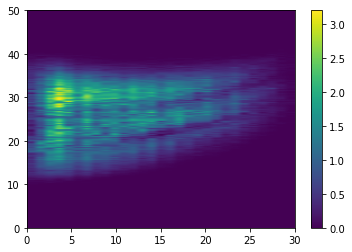

In [10]:
dH=np.mean([np.absolute(histSumList[i,0]-histSumList[0,1]) for i in range(2)],axis=0)
histMaker(dH,binsDist,binsDif)
plt.show()

H=histSumList
distMat=np.array([[H[1,0]-H[0,0],H[1,0]-H[0,1]],
                 [H[1,1]-H[0,0],H[1,1]-H[0,1]]])
#multiply by dH, sum

# Creates graphs of the on and off axis distances to allow for visual comparing of where one excedes the other

In [11]:
def swapMatrix(histList):
    '''
    Creates a list of pairs consisting of the onAxxiss distance and the off axis distance for a given set of histograms.
    
    Input:
    
    Output: [[,],[,]]
    '''
    nOverlap=list(histList.keys())[-1][0]
    
    distanceMatrix=[]
    for i in range(nOverlap):
        distSame=np.linalg.norm(histList[i+1,0]-histList[i,0])+np.linalg.norm(histList[i+1,1]-histList[i,1])
        distDiff=np.linalg.norm(histList[i+1,1]-histList[i,0])+np.linalg.norm(histList[i+1,0]-histList[i,1])
        distanceMatrix.append([distSame,distDiff])
    
    return(np.array(distanceMatrix).T)

Loads in the maunal results

In [23]:
f=open('overlapCheck.txt','r')
manualOverlapArray=[]
for line in f:
    line=line.strip().split(',')
    manualOverlapArray.append([int(x) for x in line ])
    
manualOverlapList=[]
for i in range(len(manualOverlapArray)):
    if manualOverlapArray[i][1]==1:
        manualOverlapList.append(manualOverlapArray[i][0])
        #Check this???
print(manualOverlapArray)
print(manualOverlapList)

[[0, 1], [1, 0], [2, 0], [3, 1], [4, 0], [5, 0], [6, 0], [7, 1], [8, 0], [9, 0], [10, 0], [11, 0], [12, 1], [13, 0], [14, 1], [15, 1], [16, 0], [17, 0], [18, 0], [19, 0], [20, 0], [21, 1], [22, 0], [23, 0], [24, 0], [25, 1], [26, 1], [27, 0], [28, 0], [29, 0], [30, 1], [31, 0], [32, 1], [33, 1], [34, 0], [35, 0], [36, 0], [37, 0], [38, 0], [39, 0], [40, 1], [41, 1], [42, 0], [43, 1], [44, 1], [45, 0], [46, 0], [47, 0], [48, 0], [49, 0], [50, 1], [51, 1], [52, 0], [53, 1], [54, 1], [55, 0], [56, 1], [57, 1], [58, 1], [59, 0]]
[0, 3, 7, 12, 14, 15, 21, 25, 26, 30, 32, 33, 40, 41, 43, 44, 50, 51, 53, 54, 56, 57, 58]


In [13]:
def swapLister(distanceMatrix):
    '''
    Displays a list of all the nonoverlapping ranges in which swaps occur according to the on/off axis distances of the imput matricies.
    
    '''
    swapList=[]
    
    for i in range(len(distanceMatrix.T)):
        if distanceMatrix.T[i][1]>distanceMatrix.T[i][0]:
            swapList.append(i)
        
    return(swapList)

### Sum histograms

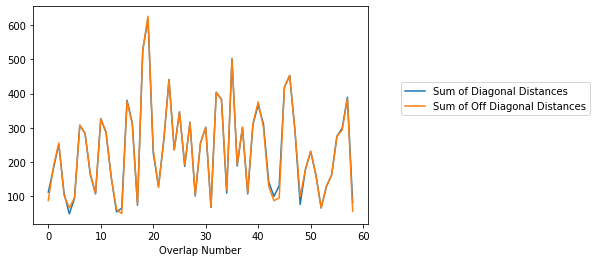

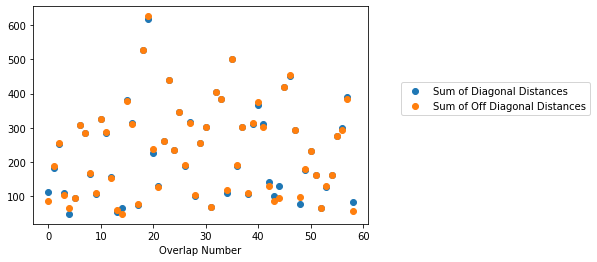

In [26]:
distanceMatrix=swapMatrix(histSumList)

plt.plot(distanceMatrix[0],label='Sum of Diagonal Distances')
plt.plot(distanceMatrix[1],label='Sum of Off Diagonal Distances')
plt.xlabel('Overlap Number')
plt.legend(loc=(1.1,.5))
plt.show()

plt.scatter(np.linspace(0,len(distanceMatrix[0])-1,len(distanceMatrix[0])),distanceMatrix[0],label='Sum of Diagonal Distances')
plt.scatter(np.linspace(0,len(distanceMatrix[1])-1,len(distanceMatrix[1])),distanceMatrix[1],label='Sum of Off Diagonal Distances')
plt.xlabel('Overlap Number')
plt.legend(loc=(1.1,.5))
plt.show()

In [27]:
print(swapLister(swapMatrix(histSumList)))
print(manualOverlapList)
print(np.intersect1d(swapLister(swapMatrix(histSumList)),manualOverlapList))

[1, 2, 4, 5, 6, 8, 9, 11, 13, 17, 19, 20, 26, 28, 31, 34, 36, 37, 38, 39, 40, 46, 47, 48, 49, 53]
[0, 3, 7, 12, 14, 15, 21, 25, 26, 30, 32, 33, 40, 41, 43, 44, 50, 51, 53, 54, 56, 57, 58]
[26 40 53]


### Difference histograms

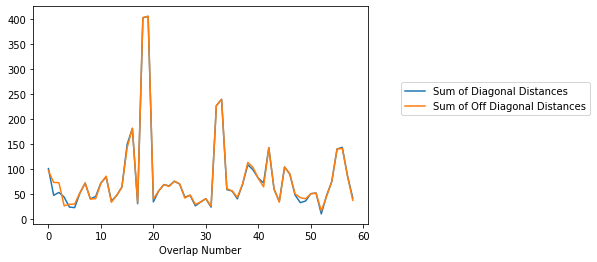

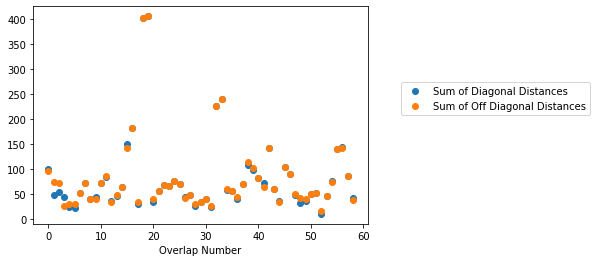

In [28]:
distanceMatrix=swapMatrix(histDifList)

plt.plot(distanceMatrix[0],label='Sum of Diagonal Distances')
plt.plot(distanceMatrix[1],label='Sum of Off Diagonal Distances')
plt.xlabel('Overlap Number')
plt.legend(loc=(1.1,.5))
plt.show()

plt.scatter(np.linspace(0,len(distanceMatrix[0])-1,len(distanceMatrix[0])),distanceMatrix[0],label='Sum of Diagonal Distances')
plt.scatter(np.linspace(0,len(distanceMatrix[1])-1,len(distanceMatrix[1])),distanceMatrix[1],label='Sum of Off Diagonal Distances')
plt.xlabel('Overlap Number')
plt.legend(loc=(1.1,.5))
plt.show()

In [34]:
print(swapLister(swapMatrix(histDifList)))
print(manualOverlapList)
print(np.intersect1d(swapLister(swapMatrix(histDifList)),manualOverlapList))

[1, 2, 4, 5, 6, 11, 13, 16, 17, 18, 19, 20, 24, 25, 27, 28, 31, 34, 35, 36, 37, 38, 39, 43, 46, 47, 48, 49, 52]
[0, 3, 7, 12, 14, 15, 21, 25, 26, 30, 32, 33, 40, 41, 43, 44, 50, 51, 53, 54, 56, 57, 58]
[25 43]


#### Finds differences/intersections between the sum and difference swap sets

In [30]:
print(set(swapLister(swapMatrix(histSumList)))^set(swapLister(swapMatrix(histDifList))))

{8, 9, 16, 18, 24, 25, 26, 27, 35, 40, 43, 52, 53}


In [35]:
print((reduce(np.intersect1d,(swapLister(swapMatrix(histDifList)),swapLister(swapMatrix(histSumList))))))
print(reduce(np.intersect1d,(swapLister(swapMatrix(histDifList)),swapLister(swapMatrix(histSumList)),manualOverlapList)))

[ 1  2  4  5  6 11 13 17 19 20 28 31 34 36 37 38 39 46 47 48 49]
[]


## Allow definitions of custom  bins.

In [32]:
def binReducer(x,n):
    '''
    Takes histogram data and reduces the number of bins by the imputed amount.
    
    Input: 
        x: Raw histogram data
        n: Factor by which to reduce the histogram
        
    Output:
        A histogram
    '''
    
    x=x.copy()
    
    m0=x.shape[0]//n
    m1=x.shape[1]//n
    #print(m0,m1)
    output=np.zeros((m0,m1))
    
    for i in range(n):
        #print("x",x.shape)
        while ((x.shape[1]%n!=0)|(x.shape[0]%n!=0)):
            #print("\t loop",((x.shape[1]%n!=0)&(x.shape[0]%n!=0)))
            if(x.shape[0]%n!=0):
                x[-2,:]=x[-1,:]+x[-2,:]
                x=np.delete(x,-1,0)
                #print("\t",x.shape)

            if(x.shape[1]%n!=0):
                x[:,-2]=x[:,-1]+x[:,-2]
                x=x[:,:-1]
                #print("\t",x.shape)
            #print("\t",((x.shape[1]%n!=0)&(x.shape[0]%n!=0)))

        #print("not loop")    
        output[:,:]+=x[i::n,i::n]
        #print("output",output.shape)
        return output

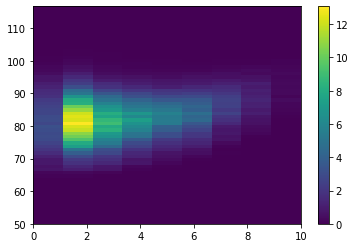

In [33]:
histMaker(binReducer(histSumList[0,0],3),binsDist/3,binsSum/3)